## Install Libraries

In [73]:
!pip install transformers~=2.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [74]:
!pip install pytorch_pretrained_bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [75]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Connect to Google Drive

In [76]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
import os
os.chdir("/content/drive/MyDrive")

## Parameters

In [78]:
#data_path = './data/capstone/CLAWS/covidhate/annotated_tweets_w_text.csv'
data_path = './data/capstone/CLAWS/covidhate/part_labeled_tweet.csv'
#data_path = './data/part_labeled_tweet.csv'

In [79]:
trainedBertModel = 'bert'

In [80]:
batchsize = 8

In [81]:
seed_num = 0

## Code

In [82]:
# Basic and System
import pandas as pd
import numpy as np
import time, datetime, random, glob, os, sys, joblib, argparse, json
# Torch
import torch
from torch.utils.data import TensorDataset, Subset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch import nn
from torch.nn import functional as F
# Pretrained Models
from pytorch_pretrained_bert import BertModel
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from tqdm import tqdm 
# Scheduler
from transformers import get_linear_schedule_with_warmup
# OPtimizer
from transformers import AdamW
# Kfold Cross Validation
from sklearn.model_selection import KFold
# Evaluation
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import seaborn as sn

In [83]:
# Global Variables
USING_GPU = False
DEVICE = None

In [84]:
# Pretrained models dictionary
# Try in the future: Albert
pretrained_models = {'bert': 'bert-base-uncased', 'roberta': 'roberta-base'}

In [85]:
random.seed(seed_num)
np.random.seed(seed_num)
torch.manual_seed(seed_num)
torch.cuda.manual_seed_all(seed_num)

In [86]:
# Format time display
def format_time(seconds):
    seconds_round = int(round((seconds)))
    return str(datetime.timedelta(seconds=seconds_round)) # hh:mm:ss

In [87]:
# Prepare data for pytorch dataloader
def prepare_dataset(sentences, labels, tokenizer, max_length=100):
    input_ids = []
    attention_masks = []
    for sent in sentences:
        # print(sent)
        try:
            encoded_dict = tokenizer.encode_plus(
                                sent,
                                add_special_tokens = True,
                                max_length = max_length,
                                truncation=True,
                                pad_to_max_length = True,
                                return_attention_mask = True,
                                return_tensors = 'pt'
                           )
        except:
            print("some tweet sent is not correct")
            print(sent)
            exit(0)

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels)
    return input_ids, attention_masks, labels

In [88]:
def train(fold, model, device, train_loader, optimizer, scheduler, epoch):
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    model.train()
    # For each batch of training data...
    for step, batch in enumerate(train_loader):
        print('step: '+str(step))
        model.zero_grad()
        
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_loader), elapsed))
        
        b_input_ids = batch[0].to(DEVICE)
        b_input_mask = batch[1].to(DEVICE)
        b_labels = batch[2].unsqueeze(0).to(DEVICE)
        #print(b_input_ids.shape)
        #print(b_input_mask.shape)
        #print(b_labels.shape)
        # https://stackoverflow.com/questions/70548318/bertforsequenceclassification-target-size-torch-size1-16-must-be-the-same
        #b_labels = torch.nn.functional.one_hot(b_labels.to(torch.int64), 3)
        #print(type(b_labels))
        #print(b_labels.shape)
        #loss, logits, hidden_states = model(b_input_ids,
        loss, logits = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)
        #print('run more')
        total_train_loss += loss.item()
        #loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

        del loss, logits

    avg_train_loss = total_train_loss / len(train_loader)

    training_time = format_time(time.time() - t0)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

Add following:
validation accuracy


In [89]:
def test(fold, model, device, test_loader, test_data_len):
    print("Running Validation...")

    model.eval()
    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    predictions, true_labels = [], []
    for batch in tqdm(test_loader, total=test_data_len):
        # b_labels are true labels
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(batch[0].to(DEVICE), token_type_ids=None,
                            attention_mask=batch[1].to(DEVICE))
            b_proba = outputs[0]
            # Accumulate the validation loss.
            #total_eval_loss += b_proba.item()

            proba = b_proba.detach().cpu().numpy()
            label_ids = batch[2].numpy()

            predictions.append(proba)
            true_labels.append(label_ids)

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += accuracy_score(label_ids, b_labels)

    #print(predictions)
    #print(true_labels)
    #print(b_labels)

In [90]:
# Wrapper function for fine-tuning
# batch size, epochs, and learning rate are from CLAWS paper
def train_bert_model(model, dataset, batch_size, epochs=3, learning_rate=1e-5, epsilon=1e-8, save_fn=None):

    if USING_GPU:
        print("Using GPU", DEVICE)
        model.cuda(DEVICE)

    # prepare cross validation
    n_fold = 5
    kfold = KFold(n_splits=n_fold, shuffle=True)

    n_accuracy = []
    n_prescision = []
    n_recall = []
    n_f1 = []

    # for each fold
    for fold, (train_idx, test_idx) in enumerate(kfold.split(dataset)):
        print()
        print('------------fold no---------{}----------------------'.format(fold))
        #print(train_idx)
        #print(test_idx)
        train_tensor = Subset(dataset, train_idx)
        test_tensor = Subset(dataset, test_idx)
        test_data_len = len(test_idx)

        trainloader = DataLoader(
            dataset,
            batch_size=batch_size,
            sampler=RandomSampler(train_tensor))
        testloader = DataLoader(
            dataset,
            batch_size=batch_size,
            sampler=SequentialSampler(test_tensor))
        
        total_steps = len(trainloader) * epochs
        optimizer = AdamW(model.parameters(),
                          lr=learning_rate,
                          eps=epsilon
                          )
        scheduler = get_linear_schedule_with_warmup(optimizer,
                               num_warmup_steps=0,  # Default value in run_glue.py
                               num_training_steps=total_steps)
        
        for epoch_i in range(0, epochs):
            print()
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            train(fold, model, DEVICE, trainloader, optimizer, scheduler, epochs)
            test(fold, model, DEVICE, testloader, test_data_len)


In [91]:
# Predict data
def run_bert_model(model, test_dataset, batch_size):    
    print('Predicting labels for {:,} test sentences...'.format(len(test_dataset)))
    
    if USING_GPU:
        print("Using GPU", DEVICE)
        model.cuda(DEVICE)

    model.eval()
    predictions , true_labels = [], []
    prediction_sampler = SequentialSampler(test_dataset)
    prediction_dataloader = DataLoader(test_dataset, sampler=prediction_sampler, batch_size=batch_size)
    for batch in tqdm(prediction_dataloader, total=len(test_dataset)):
        
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
            outputs = model(batch[0].to(DEVICE), token_type_ids=None,
                                  attention_mask=batch[1].to(DEVICE))
            b_proba = outputs[0]

            proba = b_proba.detach().cpu().numpy()
            label_ids = batch[2].numpy()

            predictions.append(proba)
            true_labels.append(label_ids)

    print('    DONE.')
   
    flat_predictions = np.concatenate(predictions, axis=0)
    return flat_predictions

In [92]:
# If there's a GPU available...
if torch.cuda.is_available():
    # Tell PyTorch to use the GPU.    
    DEVICE = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
    USING_GPU = True
else:
    print('No GPU available, using the CPU instead.')
    DEVICE = torch.device("cpu")
    USING_GPU = False

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [93]:
df = pd.read_csv(data_path)
df = df[df['Text'].notna()]
X = df.Text.values # x
Y = list(df['label']) # y_true

## BERT

In [94]:
if trainedBertModel == 'bert':
    used_bert_model = pretrained_models[trainedBertModel]
    model = BertForSequenceClassification.from_pretrained(used_bert_model, num_labels = 3)
    tokenizer = BertTokenizer.from_pretrained(used_bert_model, do_lower_case=True)
elif trainedBertModel == 'roberta':
    used_bert_model = pretrained_models[trainedBertModel]
    model = RobertaForSequenceClassification.from_pretrained(used_bert_model, num_labels = 3)
    tokenizer = RobertaTokenizer.from_pretrained(used_bert_model, do_lower_case=True)

input_ids, attention_masks, labels = prepare_dataset(X, Y, tokenizer, max_length=400)
dataset = TensorDataset(input_ids, attention_masks, labels)

### 5-fold cross validation

In [95]:
train_bert_model(model, dataset, batch_size=batchsize)

Using GPU cuda
------------fold no---------0----------------------
[ 0  1  3  4  5  6  7  8  9 11 12 14 15 16 17 18 19 20 21 22 23 25 27 29]
[ 2 10 13 24 26 28]
======== Epoch 1 / 3 ========
Training...
step: 0
step: 1
step: 2

  Average training loss: 1.17
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  6.35it/s]

======== Epoch 2 / 3 ========
Training...
step: 0


step: 1
step: 2

  Average training loss: 1.07
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  6.35it/s]

======== Epoch 3 / 3 ========
Training...
step: 0


step: 1
step: 2

  Average training loss: 0.99
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  6.07it/s]

------------fold no---------1----------------------
[ 0  1  2  3  4  6  7  8  9 10 12 13 14 15 18 19 20 21 23 24 25 26 28 29]
[ 5 11 16 17 22 27]
======== Epoch 1 / 3 ========
Training...
step: 0


step: 1
step: 2

  Average training loss: 0.97
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  6.01it/s]

======== Epoch 2 / 3 ========
Training...
step: 0


step: 1
step: 2

  Average training loss: 0.90
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  6.06it/s]

======== Epoch 3 / 3 ========
Training...
step: 0


step: 1
step: 2

  Average training loss: 0.92
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  6.17it/s]

------------fold no---------2----------------------
[ 0  2  3  4  5  6  7  9 10 11 12 13 15 16 17 18 19 21 22 24 25 26 27 28]
[ 1  8 14 20 23 29]
======== Epoch 1 / 3 ========
Training...
step: 0


step: 1
step: 2

  Average training loss: 0.82
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  5.84it/s]

======== Epoch 2 / 3 ========
Training...
step: 0


step: 1
step: 2

  Average training loss: 0.82
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  5.79it/s]

======== Epoch 3 / 3 ========
Training...
step: 0


step: 1
step: 2

  Average training loss: 0.79
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  6.29it/s]

------------fold no---------3----------------------
[ 0  1  2  3  5  8 10 11 12 13 14 15 16 17 20 21 22 23 24 25 26 27 28 29]
[ 4  6  7  9 18 19]
======== Epoch 1 / 3 ========
Training...
step: 0


step: 1
step: 2

  Average training loss: 0.76
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  5.60it/s]

======== Epoch 2 / 3 ========
Training...
step: 0


step: 1
step: 2

  Average training loss: 0.73
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  5.70it/s]

======== Epoch 3 / 3 ========
Training...
step: 0


step: 1
step: 2

  Average training loss: 0.74
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  5.73it/s]

------------fold no---------4----------------------
[ 1  2  4  5  6  7  8  9 10 11 13 14 16 17 18 19 20 22 23 24 26 27 28 29]
[ 0  3 12 15 21 25]
======== Epoch 1 / 3 ========
Training...
step: 0


step: 1
step: 2

  Average training loss: 0.72
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  5.59it/s]

======== Epoch 2 / 3 ========
Training...
step: 0


step: 1
step: 2

  Average training loss: 0.65
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  5.63it/s]

======== Epoch 3 / 3 ========
Training...
step: 0


step: 1
step: 2

  Average training loss: 0.61
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  5.56it/s]


### Predict

In [96]:
y_pred = np.zeros(len(X))

flat_logits = run_bert_model(model, dataset, batch_size=batchsize)
y_pred = np.argmax(flat_logits, axis=1).flatten()

df['BERT_label'] = y_pred

Predicting labels for 30 test sentences...
Using GPU cuda


 13%|█▎        | 4/30 [00:00<00:05,  4.84it/s]

    DONE.


## ROBERTA

In [97]:
trainedBertModel = 'roberta'

In [98]:
if trainedBertModel == 'bert':
    used_bert_model = pretrained_models[trainedBertModel]
    model = BertForSequenceClassification.from_pretrained(used_bert_model, num_labels = 3)
    tokenizer = BertTokenizer.from_pretrained(used_bert_model, do_lower_case=True)
elif trainedBertModel == 'roberta':
    used_bert_model = pretrained_models[trainedBertModel]
    model = RobertaForSequenceClassification.from_pretrained(used_bert_model, num_labels = 3)
    tokenizer = RobertaTokenizer.from_pretrained(used_bert_model, do_lower_case=True)

input_ids, attention_masks, labels = prepare_dataset(X, Y, tokenizer, max_length=400)
dataset = TensorDataset(input_ids, attention_masks, labels)

### 5-fold cross validation

In [99]:
train_bert_model(model, dataset, batch_size=batchsize)

Using GPU cuda
------------fold no---------0----------------------
[ 0  1  2  3  4  7  9 10 11 12 14 15 17 18 19 21 22 23 24 25 26 27 28 29]
[ 5  6  8 13 16 20]
======== Epoch 1 / 3 ========
Training...
step: 0
step: 1
step: 2

  Average training loss: 1.09
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  6.95it/s]

======== Epoch 2 / 3 ========
Training...
step: 0


step: 1
step: 2

  Average training loss: 1.07
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  6.38it/s]

======== Epoch 3 / 3 ========
Training...
step: 0


step: 1
step: 2

  Average training loss: 1.03
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  6.28it/s]

------------fold no---------1----------------------
[ 0  1  3  5  6  7  8  9 10 13 14 15 16 17 18 19 20 21 22 23 24 27 28 29]
[ 2  4 11 12 25 26]
======== Epoch 1 / 3 ========
Training...
step: 0


step: 1
step: 2

  Average training loss: 0.99
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  6.46it/s]

======== Epoch 2 / 3 ========
Training...
step: 0


step: 1
step: 2

  Average training loss: 0.96
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  6.50it/s]

======== Epoch 3 / 3 ========
Training...
step: 0


step: 1
step: 2

  Average training loss: 0.97
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  6.13it/s]

------------fold no---------2----------------------
[ 0  2  3  4  5  6  7  8 11 12 13 14 15 16 17 18 19 20 21 22 24 25 26 29]
[ 1  9 10 23 27 28]
======== Epoch 1 / 3 ========
Training...
step: 0


step: 1
step: 2

  Average training loss: 0.92
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  6.32it/s]

======== Epoch 2 / 3 ========
Training...
step: 0


step: 1
step: 2

  Average training loss: 0.86
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  6.25it/s]

======== Epoch 3 / 3 ========
Training...
step: 0


step: 1
step: 2

  Average training loss: 0.85
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  6.39it/s]

------------fold no---------3----------------------
[ 0  1  2  3  4  5  6  8  9 10 11 12 13 15 16 18 20 23 24 25 26 27 28 29]
[ 7 14 17 19 21 22]
======== Epoch 1 / 3 ========
Training...
step: 0


step: 1
step: 2

  Average training loss: 0.79
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  6.32it/s]

======== Epoch 2 / 3 ========
Training...
step: 0


step: 1
step: 2

  Average training loss: 0.78
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  6.33it/s]

======== Epoch 3 / 3 ========
Training...
step: 0


step: 1
step: 2

  Average training loss: 0.78
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  6.24it/s]

------------fold no---------4----------------------
[ 1  2  4  5  6  7  8  9 10 11 12 13 14 16 17 19 20 21 22 23 25 26 27 28]
[ 0  3 15 18 24 29]
======== Epoch 1 / 3 ========
Training...
step: 0


step: 1
step: 2

  Average training loss: 0.76
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  6.51it/s]

======== Epoch 2 / 3 ========
Training...
step: 0


step: 1
step: 2

  Average training loss: 0.68
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  6.32it/s]

======== Epoch 3 / 3 ========
Training...
step: 0


step: 1
step: 2

  Average training loss: 0.66
  Training epoch took: 0:00:02
Running Validation...


 17%|█▋        | 1/6 [00:00<00:00,  6.33it/s]


## Predict

In [100]:
y_pred = np.zeros(len(X))

flat_logits = run_bert_model(model, dataset, batch_size=batchsize)
y_pred = np.argmax(flat_logits, axis=1).flatten()

df['ROBERTA_label'] = y_pred

Predicting labels for 30 test sentences...
Using GPU cuda


 13%|█▎        | 4/30 [00:00<00:04,  5.60it/s]

    DONE.


## Evaluation

In [101]:
df.head(30)

,Tweet ID,Text,label,BERT_label,ROBERTA_label
0,1242553623260868608,Are we still allowed to quote ancient Chinese ...,0,0,0
1,1246508137638580225,@mamacat2u @VBeltiz More power to you! This C...,0,0,0
2,1233468243534372865,"CNBC: WHO, Tedros reiterated that the virus co...",0,0,0
3,1243626072387747841,"""The heightened racism experienced by Asian co...",1,0,0
4,1225611530978217989,Coronavirus and Nepali in China: KP Oli has di...,0,0,0
5,1238081115182764032,#IamNotAVirus - heard of it @thetimes ? Why us...,1,0,0
6,1246282568414179329,@RepAdamSchiff You have proven over the past 3...,0,0,0
7,1232094383924707328,@realDonaldTrump Fact: Coronavirus will probab...,0,0,0
8,1238072679694864384,for the last fucking time.... CORONAVIRUS IS N...,1,0,0
9,1245152684820348929,@realDonaldTrump I think your campaign slogan ...,0,0,0


### BERT

In [102]:
cf_matrix = confusion_matrix(df['label'], df['BERT_label'])

In [103]:
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in range(3)],
                     columns = [i for i in range(3)])

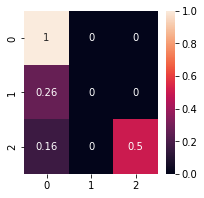

In [104]:
plt.figure(figsize = (3,3))
sn.heatmap(df_cm, annot=True)
plt.show()

In [105]:
print(metrics.classification_report(df['label'], df['BERT_label'], digits=3))

              precision    recall  f1-score   support

           0      0.704     1.000     0.826        19
           1      0.000     0.000     0.000         5
           2      1.000     0.500     0.667         6

    accuracy                          0.733        30
   macro avg      0.568     0.500     0.498        30
weighted avg      0.646     0.733     0.657        30



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### ROBERTA

In [106]:
cf_matrix = confusion_matrix(df['label'], df['ROBERTA_label'])

In [107]:
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1), index = [i for i in range(3)],
                     columns = [i for i in range(3)])

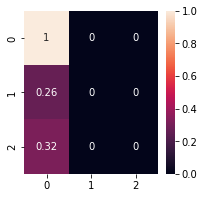

In [108]:
plt.figure(figsize = (3,3))
sn.heatmap(df_cm, annot=True)
plt.show()

In [109]:
print(metrics.classification_report(df['label'], df['ROBERTA_label'], digits=3))

              precision    recall  f1-score   support

           0      0.633     1.000     0.776        19
           1      0.000     0.000     0.000         5
           2      0.000     0.000     0.000         6

    accuracy                          0.633        30
   macro avg      0.211     0.333     0.259        30
weighted avg      0.401     0.633     0.491        30



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
